In [1]:
import torch
from inference import predict_from_checkpoint
from finpak.data.fetchers.yahoo import download_multiple_tickers
from preprocessing import combine_price_series

In [2]:

tickers = [
    'AMD', 'AVGO', 'UAL'
]
start_date = '1990-01-01'
end_date = '2024-11-02'    

# Download historical data for the tickers
data_df = download_multiple_tickers(tickers, start_date, end_date)
data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe

# Extract price series for all tickers and convert to tensors
price_series_list = []
for ticker in tickers:
    prices = data_df[ticker]
    price_tensor = torch.tensor(prices.to_numpy(), dtype=torch.float32)
    price_series_list.append(price_tensor)

# Combine price series
combined_prices = combine_price_series(price_series_list)

[*********************100%***********************]  3 of 3 completed


In [3]:
model_params_v0 = {
    "d_input": 3,
    "n_outputs": 2,
    "d_model": 512,
    "n_heads": 4,
    "n_layers": 56,
    "d_ff": 2048,
    # No dropout in inference
}


model_params_v1 = {
    "d_input": 3,
    "n_outputs": 2,
    "d_model": 1024,
    "n_heads": 8,
    "n_layers": 88,
    "d_ff": 8192,
    # No dropout in inference
}

model_params_v2 = {
    "d_input": 3,
    "n_outputs": 2,
    "d_model": 2048,
    "n_heads": 32,
    "n_layers": 96,
    "d_ff": 8192,
    # No dropout in inference
}


Making predictions for 3 start points:
Valid start indices: [8476, 8576, 8676]
Price series length: 26331
Predicting 30 steps for each start point

Processing start index 8476
Initial sequence length: 48
Generated 30 predictions

Processing start index 8576
Initial sequence length: 48
Generated 30 predictions

Processing start index 8676
Initial sequence length: 48
Generated 30 predictions

Price series stats:
Length: 26331
Non-NaN values: 8777
Value range: [1.62, 211.38]

Prediction sequence 0:
Start index: 8476
Number of predictions: 30
First few predictions (returns): tensor([ 0.0101, -0.0042, -0.0045, -0.0036, -0.0059])
Last known price: 101.80000305175781
First few predicted prices: [102.82683590655431, 102.39235931417612, 101.93463304107918, 101.5634351178642, 100.96332027908727]

Prediction sequence 1:
Start index: 8576
Number of predictions: 30
First few predictions (returns): tensor([-0.0129,  0.0017,  0.0008,  0.0009, -0.0016])
Last known price: 162.6699981689453
First few p

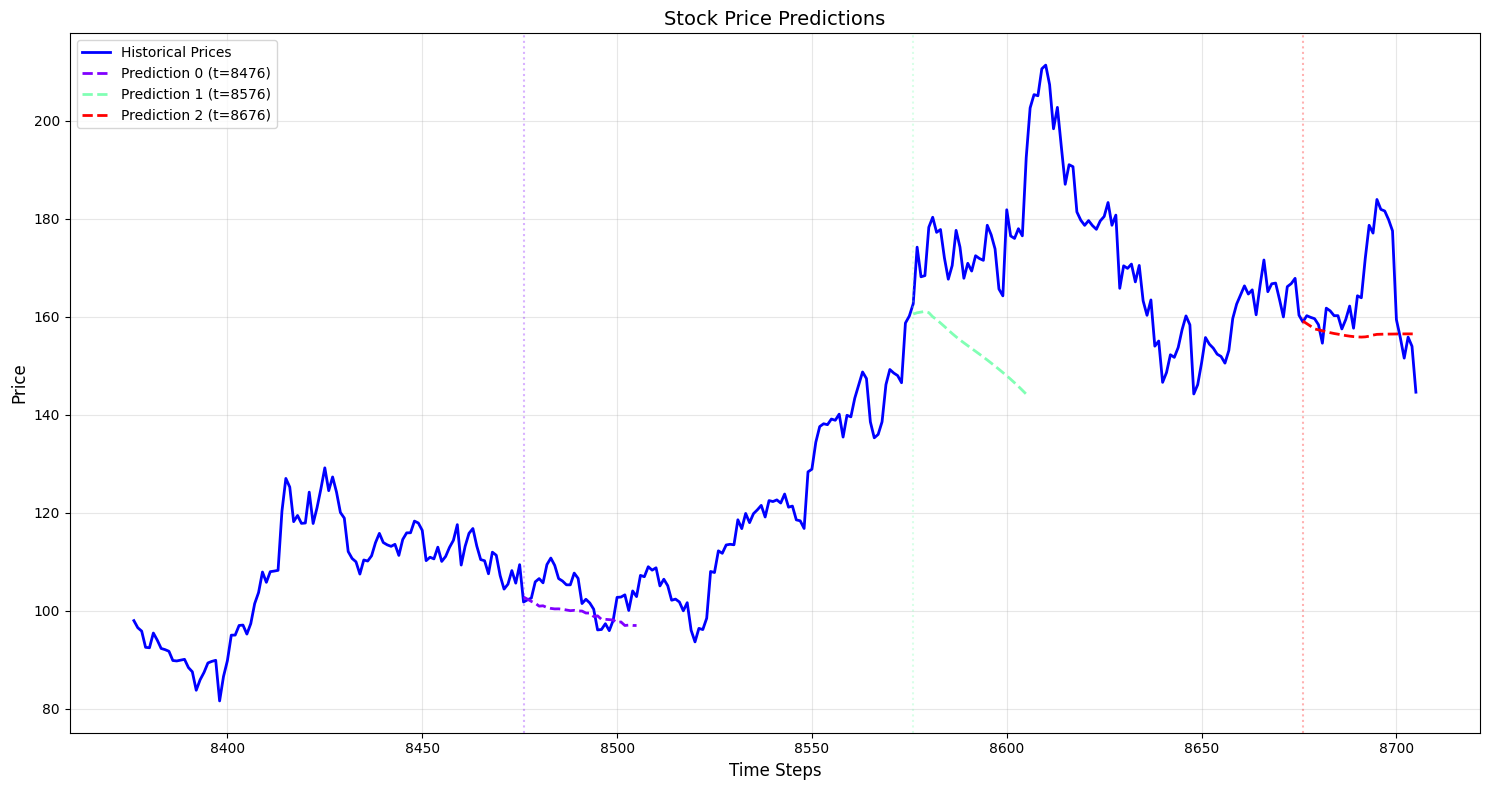

In [4]:
# # Get the last valid index
last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
start_indices = [
    last_valid_idx - 300,
    last_valid_idx - 200,
    last_valid_idx - 100
]

n_future_steps = 30
sequence_length = 47

predict_from_checkpoint(
    checkpoint_path="mv0_chkpt_e_79_valloss_0.0005491.pt",
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=model_params_v0,
    sequence_length=sequence_length,
    return_periods=[1, 5],
    sma_periods=[20]
)